In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Data Analysis
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix


# Custom Stuff
# required for importin modules from other directories
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from common import data_parser, misc
from common.model_trainer import ModelTrainer
import companies_data_preprocessor

# Data Preparation

In [2]:
df = data_parser.parse_companies(5)
raw_data, labels = companies_data_preprocessor.preprocess(df, MinMaxScaling=True, imputation=1)



# Model Training

In [3]:
params = {
    "n_estimators" : list(range(2,50)), 
    "criterion" : ["gini", "entropy"],
    "random_state" : [1],
    #"bootstrap" : ["True","False"] # Note: Bootstrapping does seem to have no affect
    }


def plot_params(data, labels, fileName="no name", title="no title"):
    # Splitting
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=1)

    modeltrainer = ModelTrainer(
        RFC, 
        params, 
        x_train, y_train, x_test, y_test, 
        companies_data_preprocessor.calculate_score, 
        thread_cnt=8
        )

    modeltrainer.train()
    modeltrainer.save_result("out/knn_params.csv")
    df = modeltrainer.result

    gini = df.loc[(df['criterion'] == "gini")]
    entropy = df.loc[(df['criterion'] == "entropy")]

    plt.style.use('seaborn')
    plt.plot(gini["n_estimators"], gini["score"], label="gini")
    plt.plot(entropy["n_estimators"], entropy["score"], label="entropy")
    plt.legend()
    plt.title(title)
    plt.ylim(-1.5, 1.5)
    plt.savefig("out/" + fileName)
    plt.show()

Finished evaluation
Best parameteters found with: {'n_estimators': 32, 'criterion': 'entropy', 'random_state': 1}
score= 0.461864406779661
Total evaluation time = 9.79s


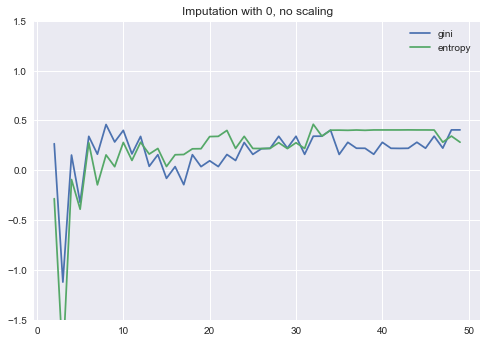

In [4]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# No Scaling

plot_params(preprocessed_data, labels, fileName="companies_rfc_Imputation_0_noScaling", title="Imputation with 0, no scaling")


Finished evaluation
Best parameteters found with: {'n_estimators': 12, 'criterion': 'entropy', 'random_state': 1}
score= 0.7100484261501211
Total evaluation time = 8.75s


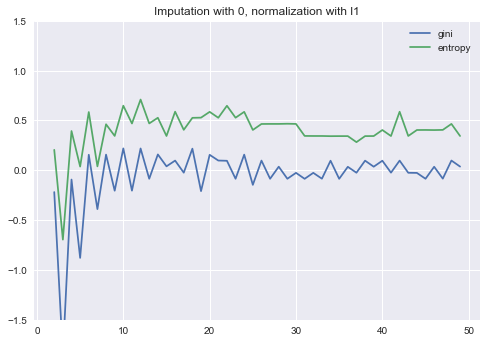

In [5]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l1 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))

plot_params(preprocessed_data, labels, fileName="companies_rfc_Imputation_0_l1Norm", title="Imputation with 0, normalization with l1")

Finished evaluation
Best parameteters found with: {'n_estimators': 22, 'criterion': 'entropy', 'random_state': 1}
score= 0.4642857142857143
Total evaluation time = 8.88s


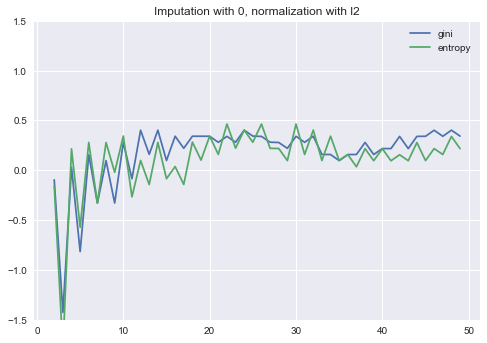

In [6]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l2 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l2").fit_transform(preprocessed_data))

plot_params(preprocessed_data, labels, fileName="companies_rfc_Imputation_0_l2Norm", title="Imputation with 0, normalization with l2")

Finished evaluation
Best parameteters found with: {'n_estimators': 41, 'criterion': 'entropy', 'random_state': 1}
score= 0.4679176755447942
Total evaluation time = 8.81s


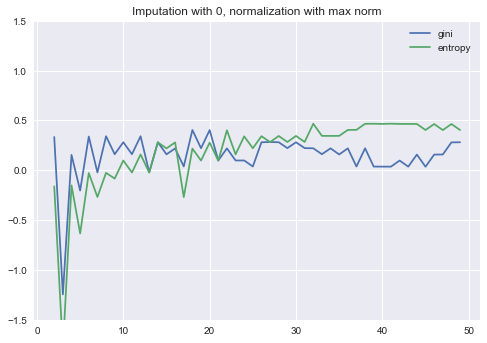

In [7]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with max norm
preprocessed_data = pd.DataFrame(Normalizer(norm="max").fit_transform(preprocessed_data))

plot_params(preprocessed_data, labels, fileName="companies_knn_Imputation_0_maxNorm", title="Imputation with 0, normalization with max norm")

# Runtime Analysis

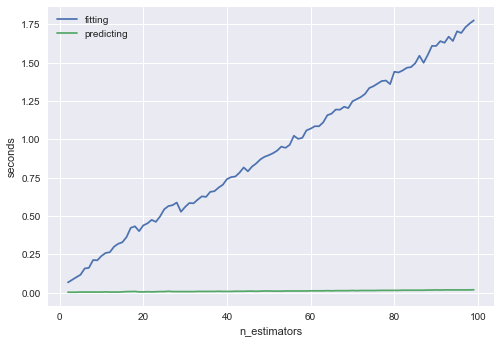

<Figure size 576x396 with 0 Axes>

In [8]:
# Simple Imputation with 0
preprocessed_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy="constant", fill_value=0).fit_transform(raw_data))

# Normalization with l1 norm
preprocessed_data = pd.DataFrame(Normalizer(norm="l1").fit_transform(preprocessed_data))

x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, labels, test_size=0.3, random_state=1)

fit_times = []
predict_times = []
n_vals = [n for n in range(2,100)]
for n in n_vals:
    model = RFC(n_estimators=n, criterion="entropy")
    
    # Fitting
    start_time = time.time()
    model.fit(x_train, y_train)
    end_time = time.time()
    fit_times.append(end_time - start_time)

    # Predicting
    start_time = time.time()
    model.predict(x_test)
    end_time = time.time()
    predict_times.append(end_time - start_time)

plt.plot(n_vals, fit_times, label="fitting")
plt.plot(n_vals, predict_times, label="predicting")
plt.ylabel("seconds")
plt.xlabel("n_estimators")
plt.legend()
plt.show()
plt.savefig("out/knn_runtime")

In [ ]:
calculate_score(y_test, y_test)